# Collect final results into tables

In [1]:
library(tidyverse)
library(WriteXLS)
library(knitr)
library(IRdisplay)
library(gridExtra)
library(VennDiagram)
library(patchwork)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: grid

Loading required package: futile.logger


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:lubridate’:

    stamp




## Paths 

In [2]:
# Results for analysis done with clinical end point having highest number of events 
results.root.dir = "/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_cancer_type"
# List the directories for each cancer type
cancer.dirs = list.files(results.root.dir)

# If rerun remove 
#cancer.dirs = cancer.dirs[!(cancer.dirs %in% c("tables","figures"))]

# Path to result when using clinical and gene based features 
clinical.and.gene.path = "Penalized_Cox_risk_prediction/customer_features/With_clinical_features"

# Store the results 
clinical.and.gene.ls = list()

# The output dir 
out.dir = "/lustre/projects/landstrom_core/results/prognostic_model_development/Manuscript_tables_revised/" 
dir.create(out.dir)

out.dir.figures = "/lustre/projects/landstrom_core/results/prognostic_model_development/Manuscript_figures_revised"
dir.create(out.dir.figures)

Warning message in dir.create(out.dir):
“'/lustre/projects/landstrom_core/results/prognostic_model_development/Manuscript_tables_revised' already exists”
Warning message in dir.create(out.dir.figures):
“'/lustre/projects/landstrom_core/results/prognostic_model_development/Manuscript_figures_revised' already exists”


In [3]:
cancer.dirs

[1] "ACC"           "BLCA"          "BRCA"          "CESC"         
 [5] "CHOL"          "COAD"          "DLBC"          "ESCA"         
 [9] "GBM"           "HNSC"          "KICH"          "KIRC"         
[13] "KIRP"          "LAML"          "LGG"           "LIHC"         
[17] "LUAD"          "LUSC"          "MESO"          "OV"           
[21] "PAAD"          "PCPG"          "PRAD"          "READ"         
[25] "READ_and_COAD" "SARC"          "SKCM"          "STAD"         
[29] "TGCT"          "THCA"          "THYM"          "UCEC"         
[33] "UVM"

In [4]:
length(cancer.dirs)

[1] 33

## Prepare table models taking into account clinical and gene based features

In [5]:
for (ctype in cancer.dirs) {
    
    fsize = file.info(file.path(results.root.dir,ctype, clinical.and.gene.path, "Final_evaluation_results_training.csv"))$size
    
    if (fsize > 10) {
    
        # Read in training data 
        tb.train = read.csv(file.path(results.root.dir,ctype, clinical.and.gene.path, "Final_evaluation_results_training.csv"), check.names = F)
    
        # Select relevant column and rename 
        tb.train = tb.train %>% 
             dplyr::select(`End point`, N, Pvalue.pval) %>%
             dplyr::rename("N (Training)" = "N",
                           "P-value (Training)" = "Pvalue.pval")
        
        # Read in C-index data 
        tb.cindex.train = read.csv(file.path(results.root.dir,ctype, clinical.and.gene.path, "Final_evaluation_C_index_training.csv"), check.names = F)
        tb.cindex.train = tb.cindex.train %>% 
                                    dplyr::rename("C-index (Training)" = "C-index",
                                                 "C-index CI (Training)" = "C-index CI")
        
        tb.auc.train = read.csv(file.path(results.root.dir,ctype, clinical.and.gene.path, "Final_evaluation_AUC_training.csv"), check.names = F)
        tb.auc.train = tb.auc.train %>% 
                                    dplyr::rename("AUC 1y (Training)" = "AUC (1y)",
                                                  "AUC 3y (Training)" = "AUC (3y)",
                                                  "AUC 5y (Training)" = "AUC (5y)")
    
        # Read in validation data 
        tb.valid = read.csv(file.path(results.root.dir, ctype, clinical.and.gene.path, "Final_evaluation_results_validation.csv"), check.names = F)
       
        tb.valid = tb.valid %>% 
             dplyr::select(`End point`, N, Pvalue.pval) %>%
             dplyr::rename("N (Validation)" = "N", 
                          "P-value (Validation)" = "Pvalue.pval")
            
        # Read in C-index data
        tb.cindex.valid = read.csv(file.path(results.root.dir,ctype, clinical.and.gene.path, "Final_evaluation_C_index_validation.csv"),check.names = F)        
        tb.cindex.valid = tb.cindex.valid %>% 
                          dplyr::rename("C-index (Validation)" = "C-index",
                                        "C-index CI (Validation)" = "C-index CI")
        
        tb.auc.valid = read.csv(file.path(results.root.dir,ctype, clinical.and.gene.path, "Final_evaluation_AUC_validation.csv"), check.names = F)
        tb.auc.valid = tb.auc.valid %>% 
                                    dplyr::rename("AUC 1y (Validation)" = "AUC (1y)",
                                                  "AUC 3y (Validation)" = "AUC (3y)",
                                                  "AUC 5y (Validation)" = "AUC (5y)")       
          
        # Merge 
        tb.merged = left_join(tb.train, tb.valid, by = c("End point"))
        tb.cindex.merged = left_join(tb.cindex.train, tb.cindex.valid, by = c("End point"))
        tb.auc.merged = left_join(tb.auc.train, tb.auc.valid, by = c("End point"))
        tb.merged.final = left_join(tb.merged, tb.cindex.merged, by = c("End point"))
        tb.merged.final = left_join(tb.merged.final, tb.auc.merged, by = c("End point"))
        clinical.and.gene.ls[[ctype]] = tb.merged.final
    
    } 
}

In [6]:
#Convert into a single table 
final.table.clinical.and.gene.feat = bind_rows(clinical.and.gene.ls, .id = "Cancer type")

In [7]:
# Write full results into a table 
write.csv(final.table.clinical.and.gene.feat, file.path(out.dir, "Evaluation_results_all_prognostic_models.csv"))

## Prepare table of model taking only the clinical features into consideration

In [8]:
# Path to results when using only clinical features
clinical.only.path = "Penalized_Cox_risk_prediction/customer_features/Only_clinical_features"

# Store the results 
clinical.only.ls = list()

In [9]:
for (ctype in cancer.dirs) {
    
    print(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_results_training.csv"))
    print(file.info(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_results_training.csv"))$size)
    fsize = file.info(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_results_training.csv"))$size
    
    if (fsize > 10) {
    
        # Read in training data 
        tb.train = read.csv(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_results_training.csv"), check.names = F)
    
        # Select relevant column and rename 
        tb.train = tb.train %>% 
             dplyr::select("End point", N, Pvalue.pval) %>%
             dplyr::rename("N (Training)" = "N",
                           "P-value (Training)" = "Pvalue.pval")
        
        # Read in C-index data 
        tb.cindex.train = read.csv(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_C_index_training.csv"), check.names = F)
        tb.cindex.train = tb.cindex.train %>% 
                                    dplyr::rename("C-index (Training)" = "C-index",
                                                 "C-index CI (Training)" = "C-index CI")
        
        tb.auc.train = read.csv(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_AUC_training.csv"), check.names = F)
        tb.auc.train = tb.auc.train %>% 
                                    dplyr::rename("AUC 1y (Training)" = "AUC (1y)",
                                                  "AUC 3y (Training)" = "AUC (3y)",
                                                  "AUC 5y (Training)" = "AUC (5y)")
    
        # Read in validation data 
        tb.valid = read.csv(file.path(results.root.dir, ctype, clinical.only.path, "Final_evaluation_results_validation.csv"), check.names = F)
          
        tb.valid = tb.valid %>% 
             dplyr::select("End point", N, Pvalue.pval) %>%
             dplyr::rename("N (Validation)" = "N", 
                           "P-value (Validation)" = "Pvalue.pval")
        
        
        # Read in C-index data 
        tb.cindex.valid = read.csv(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_C_index_validation.csv"), check.names = F)
        tb.cindex.valid = tb.cindex.valid %>% 
                                    dplyr::rename("C-index (Validation)" = "C-index",
                                                  "C-index CI (Validation)" = "C-index CI")
        
        tb.auc.valid = read.csv(file.path(results.root.dir,ctype, clinical.only.path, "Final_evaluation_AUC_validation.csv"), check.names = F)
        tb.auc.valid = tb.auc.valid %>% 
                                    dplyr::rename("AUC 1y (Validation)" = "AUC (1y)",
                                                  "AUC 3y (Validation)" = "AUC (3y)",
                                                  "AUC 5y (Validation)" = "AUC (5y)")
            
        # Merge 
        tb.merged = left_join(tb.train, tb.valid, by = c("End point"))
        tb.cindex.merged = left_join(tb.cindex.train, tb.cindex.valid, by = c("End point"))
        tb.auc.merged = left_join(tb.auc.train, tb.auc.valid, by = c("End point"))
        tb.merged.final = left_join(tb.merged, tb.cindex.merged, by = c("End point"))
        tb.merged.final = left_join(tb.merged.final, tb.auc.merged, by = c("End point"))
        clinical.only.ls[[ctype]] = tb.merged.final
    } 
}

[1] "/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_cancer_type/ACC/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/Final_evaluation_results_training.csv"
[1] 308
[1] "/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_cancer_type/BLCA/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/Final_evaluation_results_training.csv"
[1] 329
[1] "/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_cancer_type/BRCA/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/Final_evaluation_results_training.csv"
[1] 332
[1] "/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_cancer_type/CESC/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/Final_evaluation_results_training.csv"
[1] 315
[1] "/lustre/projects/landstrom_core/results/prognostic_model_development_revised/models_by_c

In [10]:
#Convert into a single table 
final.table.clinical.feat = bind_rows(clinical.only.ls, .id = "Cancer type")

In [11]:
# Write full results into a table 
write.csv(final.table.clinical.feat, file.path(out.dir, "Evaluation_results_reference_all.csv"))

## Merge the final tables 

Here we create a final table including comparison of models. We will only include the validation results

In [12]:
# Columns to remove 
cols.to.rm.prog = c("P-value (Training)", 
                    "C-index (Training)", 
                    "C-index CI (Training)", 
                    "AUC 1y (Training)",
                    "AUC 3y (Training)",
                    "AUC 5y (Training)")

cols.to.rm.ref = c("N (Training)", 
                   "N (Validation)", 
                   "P-value (Training)", 
                   "C-index (Training)", 
                   "C-index CI (Training)",
                   "AUC 1y (Training)", 
                   "AUC 3y (Training)",
                   "AUC 5y (Training)")

# Select the final columns to be included
final.table.clinical.and.gene.selected = dplyr::select(final.table.clinical.and.gene.feat, -all_of(cols.to.rm.prog))
final.table.clinical.selected =  dplyr::select(final.table.clinical.feat, -all_of(cols.to.rm.ref))

In [13]:
# Write validation results into a table 
write.csv(final.table.clinical.and.gene.selected, file.path(out.dir, "Evaluation_results_progn_valid_only.csv"))

# Write validation results into a table 
write.csv(final.table.clinical.selected, file.path(out.dir, "Evaluation_results_reference_valid_only.csv"))

In [14]:
# Merge the prog. and ref results
final.table.merged = dplyr::left_join(final.table.clinical.and.gene.selected, 
                                      final.table.clinical.selected, 
                                      by = c("Cancer type","End point"), 
                                      suffix = c(" Prog. model", " Reference model"))

In [15]:
write.csv(final.table.merged, file.path(out.dir, "Table_evaluation_progn_vs_reference_model.csv"))

## Prepare table and a venn-diagram indicating the number of significant models

In [16]:
# Indicator of significant prognostic models
signf.prog = final.table.merged$`P-value (Validation) Prog. model` < 0.05

# Indicator of significant reference model
sign.ref = final.table.merged$`P-value (Validation) Reference model` < 0.05

# Cross table
cross.table.sign = as.data.frame.matrix(table(signf.prog, sign.ref))
rownames(cross.table.sign) = paste("Sign.prog",rownames(cross.table.sign))
colnames(cross.table.sign) = paste("Sign.ref",colnames(cross.table.sign))
write.table(cross.table.sign, file.path(out.dir, "Significant_models_cross_table.tsv") ,sep = "\t", quote = F)

In [17]:
cross.table.sign

,Sign.ref FALSE,Sign.ref TRUE
,<int>,<int>
Sign.prog FALSE,67,3
Sign.prog TRUE,13,26


In [18]:
cross.table.sign

,Sign.ref FALSE,Sign.ref TRUE
,<int>,<int>
Sign.prog FALSE,67,3
Sign.prog TRUE,13,26


In [19]:
pdf(file.path(out.dir.figures, "Significant_models_venn.pdf"))
grid.newpage()
venn_object = draw.pairwise.venn(13 + 26, 
                               3 + 26, 
                               26, 
                               category = c("Prognostic model","Reference model"),
                               imagetype="pdf",
                               col=c("#440154ff", '#21908dff'),
                               fill = c(alpha("#440154ff",0.3), alpha('#21908dff',0.3)),
                               cex = 2,
                               fontfamily = "sans",
                               cat.cex = 2,
                               cat.pos = c(-30, 23),
                               cat.dist = c(0.05, 0.06))
grid.draw(venn_object)
dev.off()

png 
  2

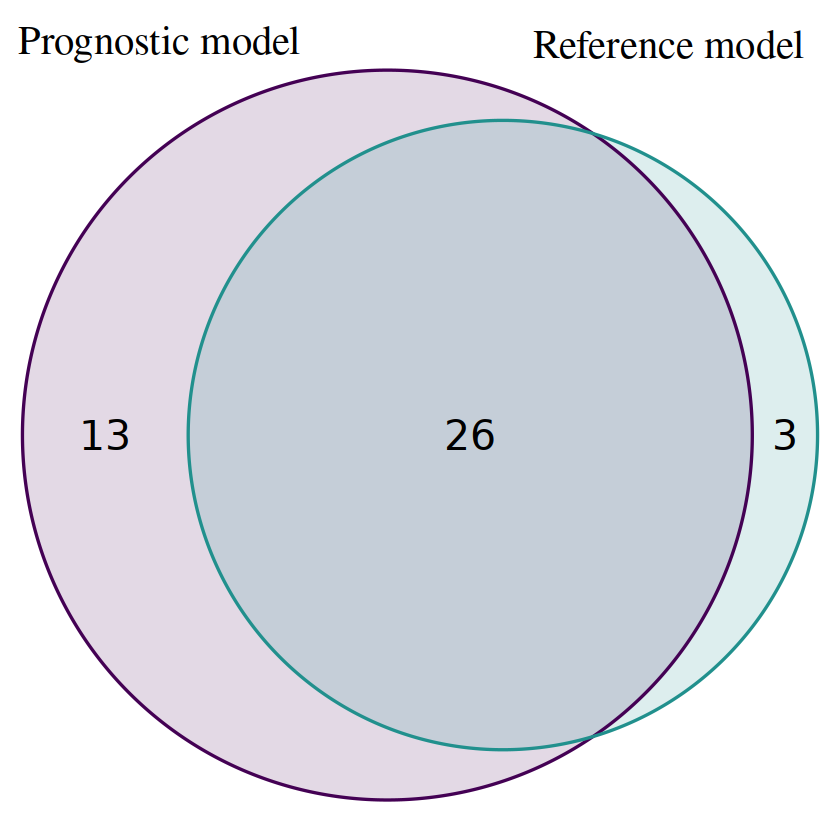

In [20]:
grid.draw(venn_object)

## Scatterplot 

In [21]:
library(ggrepel)

In [22]:
data.for.scplot = data.frame(y = final.table.merged$`P-value (Validation) Prog. model`, 
           x = final.table.merged$`P-value (Validation) Reference model`,
           cancer.type = final.table.merged$`Cancer type`,
           end.point = final.table.merged$`End point`)

In [23]:
gg = data.for.scplot %>% 
    ggplot(aes(-log10(x), -log10(y), colour = end.point, label = cancer.type)) + geom_text_repel(size = 3) + geom_point(size = 3) + theme_minimal() + 
    geom_vline(xintercept = -log10(0.05), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    scale_color_manual(values = c("DSS"="#0077BB", 
                                  "DFI"="#EE3377", 
                                  "OS"="#EE7733",
                                  "PFI"="#009988")) + 
    theme(axis.text.x = element_text(colour = "black"),
          axis.text.y = element_text(colour = "black"),
          legend.position="top") +
    xlim(c(0,8)) + ylim(c(0,8)) + coord_fixed()

Warning message:
“ggrepel: 75 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


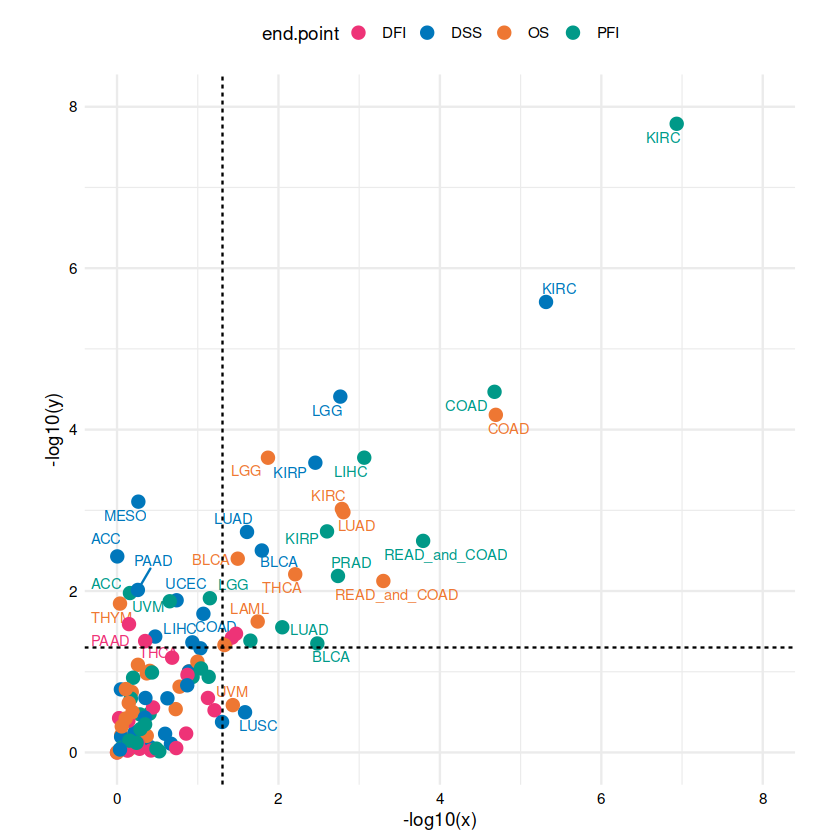

In [24]:
gg

In [25]:
ggsave(plot = gg, filename = file.path(out.dir.figures, "Model_scatterplot_results.pdf"), width = 8, height =  8)

Warning message:
“ggrepel: 67 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [26]:
saveRDS(object = data.for.scplot, file = "scatter_plot_input.rds")

## Table including the significant features

In [27]:
significant.features.all.ls = list()

for (ctype in cancer.dirs) {
    robj = readRDS(file.path(results.root.dir, ctype, "Final_results_collection.rds"))
    significant.features.ls = robj$FSS2_regcox_res_with_clin
    features.vect = map_chr(significant.features.ls, function(x){paste(x$Feature, collapse = ",")})
    features.df = data.frame("End point" = names(significant.features.ls),
                             "Feature" = features.vect, check.names = F)
    
    rownames(features.df) = NULL
    
    significant.features.all.ls[[ctype]] = features.df
    
}
significant.features.all.df = do.call("rbind", significant.features.all.ls) 

In [28]:
significant.features.all.df = significant.features.all.df %>% 
                                       tibble::rownames_to_column("Cancer type") 
                 
significant.features.all.df$`Cancer type` = map_chr(significant.features.all.df$`Cancer type`, function(x){unlist(strsplit(x, split = "\\."))[1]})

In [29]:
final.table.merged.with.features = left_join(final.table.merged, significant.features.all.df, c("Cancer type","End point")) 

In [30]:
# Helper function for fixing variable names 
fixVarNames = function(x){
    if (str_detect(x, "Gender")) {
        return("Gender")
    } else if (str_detect(x, "Tumor.stage")){
        return("Tumor stage")
    } else if (str_detect(x,".cn")){
        if (str_ends(x,"\\.cn-1")){
            return(str_replace(x, "\\.cn-1"," deletion"))
        } else {
            return(str_replace(x, "\\.cn1"," amplification"))
        }
    } else if (str_detect(x, "Gleason.group")){ 
        return("Gleason group")
    } else if (str_detect(x, "\\.exp")){
        return(str_replace(x, "\\.exp"," expression"))
    } else {
        return(x)
    }
}
# Compress the feature list
compressFeatList = function(x){
    sp = unlist(strsplit(x, ","))
    final = unique(map_chr(sp, fixVarNames))
    return(paste(final, collapse = ","))
}

# Compress the feature lists 
final.table.merged.with.features$Feature = map_chr(final.table.merged.with.features$Feature,  compressFeatList)

In [31]:
write.csv(final.table.merged.with.features, file.path(out.dir, "Table_evaluation_best_clin_end_with_reference_features_inc.csv"))

## Prepare a bar chart showing the frequencies how features occur in the significant models

### New figure

In [32]:
# Function for expanding the feature column
expandFeatCol = function(x) {
    
    # Features 
    feats = unlist(strsplit(x[["Feature"]], ","))
    row.elem = x[names(x) != "Feature"]
    df = t(as.data.frame(row.elem, check.names = F))
    dup.df = as.data.frame(rbind(df, df[rep(1, length(feats) -1 ),]), check.names = F)
    dup.df = data.frame(dup.df, "Features" = feats, check.names = F)
    return(dup.df)
}

# Expand the feature column
final.table.merged.with.features.expanded = apply(final.table.merged.with.features,1, expandFeatCol)
final.table.merged.with.features.expanded = bind_rows(final.table.merged.with.features.expanded)

# Include only significant according to log-rank test
final.table.merged.with.features.expanded.sig = final.table.merged.with.features.expanded[as.numeric(final.table.merged.with.features.expanded$`P-value (Validation) Prog. model`) < 0.05,]

In [33]:
# Calculate freq of features for sign. models 
features.sig = as.data.frame(table(final.table.merged.with.features.expanded.sig$Features))
colnames(features.sig) = c("Feature", "Freq")

In [34]:
# Merge tumor stage and Gleason group 
features.sig = tibble::add_row(features.sig, 
                Feature = "Tumor stage / Gleason group", 
                Freq = features.sig$Freq[features.sig$Feature == "Gleason group"] + 
                features.sig$Freq[features.sig$Feature == "Tumor stage"])

features.sig = dplyr::filter(features.sig, !(Feature %in% c("Gleason group","Tumor stage")))

In [35]:
assigFeatType = function(x){
    if ((x == "Tumor stage / Gleason group") | (x == "Age.clin") | (x == "Gender")){
        return("Clinical")
    } else if (str_detect(x, "expression")){
        return("Expression")
    } else if (str_detect(x, "amplification")){ 
        return("Amplification")
    } else {
        return("Deletion")
    }
}

In [36]:
# Add feature type 
features.sig["Type"] = map_chr(features.sig[["Feature"]], assigFeatType)

In [37]:
features.sig["Type"] = factor(features.sig$Type, 
                              levels = c("Amplification", "Clinical", "Deletion", "Expression"))

In [38]:
features.sig

Feature,Freq,Type
<chr>,<int>,<fct>
Age.clin,25,Clinical
APPL1 expression,2,Expression
AR expression,8,Expression
AURKA expression,11,Expression
AURKB expression,10,Expression
Gender,21,Clinical
KIF23 expression,17,Expression
MYC amplification,1,Amplification
MYC deletion,1,Deletion


In [39]:
# Barplot based on freq for sig models 
gg.barplot.sig = features.sig  %>%  
            ggplot(aes(x = reorder(Feature, Freq), y = Freq,  fill = Type)) + 
            geom_bar(stat="identity", colour = "black") + coord_flip() + theme_classic() +
            scale_y_continuous(limits = c(0, 25), breaks = seq(from = 0, to = 25, by = 5) , expand = c(0, 0)) + 
            labs(y = "Frequency", x = "Feature") + theme(axis.text = element_text(size = 14),
                                                         axis.text.x = element_text(colour = "black"), 
                                                          axis.text.y = element_text(colour = "black"),
                                                         legend.position = "bottom")

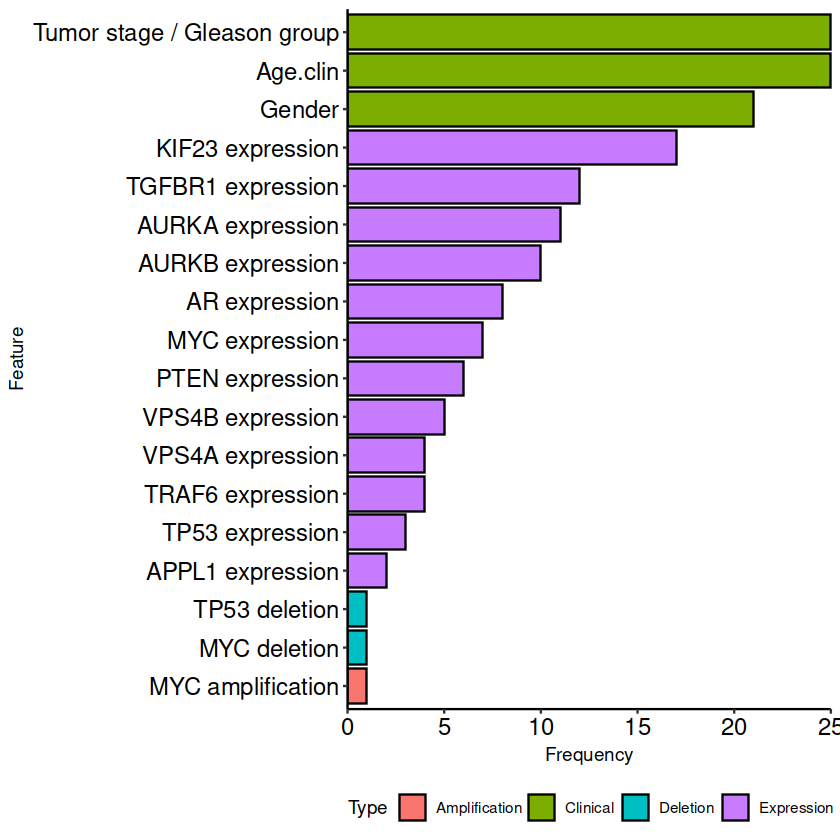

In [40]:
gg.barplot.sig

In [41]:
ggsave(gg.barplot.sig, 
       filename = file.path(out.dir.figures, "Feature_frequencies_barplot_significant_models.pdf"), 
       width = 8, height = 8)

In [42]:
ggsave(gg.barplot.sig, 
       filename = "Feature_frequencies_barplot_significant_models.pdf", 
       width = 8, height = 8)

In [43]:
# Store the results  
saveRDS(object = features.sig,  file = "barplot_input.rds")

# Forest plot 

We attempt to summarise the final evaluation results as forest plots. We will try out the following plots.

1) All C-index and confidence interval for all models
2) All C-index and confidence interval for significant progn. models (Indicate reference model C-index by hollow square)
3) Significant progn. models with highest C-index for each cancer type (Indicate reference model C-index by hollow square)

## All C-index and confidence interval for all models

In [44]:
extractCIlow = function(x){
    sp = strsplit(x, " - ")
    res = as.numeric(str_extract(sp[[1]], "\\d.+")[[1]])
    return(res)
}

extractCIupp = function(x){
    sp = unlist(strsplit(x, " - "))
    res = as.numeric(str_replace(sp[[2]], "\\)", ""))
}

In [45]:
# Indicate whether the reference model is significant based on the log-rank test 
final.table.merged$`Prog model significant` = ifelse(final.table.merged$`P-value (Validation) Prog. model` < 0.05, "Yes", "No")
final.table.merged$`Reference model significant` = ifelse(final.table.merged$`P-value (Validation) Reference model` < 0.05, "Yes", "No")

In [46]:
final.table.merged.selected  = final.table.merged %>%  
                                dplyr::select(`Cancer type`, 
                                              `End point`, 
                                              `C-index (Validation) Prog. model`, 
                                              `C-index CI (Validation) Prog. model`,
                                              `C-index (Validation) Reference model`, 
                                              `C-index CI (Validation) Reference model`,
                                               `Prog model significant`,
                                               `Reference model significant`) 

In [47]:
# Prepare new columns for confidence intervals
final.table.merged.selected$CI.lower.prog = map_dbl(final.table.merged.selected$`C-index CI (Validation) Prog. model`, extractCIlow)
final.table.merged.selected$CI.upper.prog = map_dbl(final.table.merged.selected$`C-index CI (Validation) Prog. model`, extractCIupp)
final.table.merged.selected$CI.lower.ref = map_dbl(final.table.merged.selected$`C-index CI (Validation) Reference model`, extractCIlow)
final.table.merged.selected$CI.upper.ref = map_dbl(final.table.merged.selected$`C-index CI (Validation) Reference model`, extractCIupp)

Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning me

In [48]:
final.table.merged.selected = final.table.merged.selected %>% 
                                       dplyr::select(`Cancer type`, `End point`, `C-index (Validation) Prog. model`, 
                                                     CI.lower.prog, CI.upper.prog, `C-index (Validation) Reference model`,
                                                     CI.lower.ref, CI.upper.ref, `Prog model significant`,
                                                     `Reference model significant`)

In [49]:
final.table.merged.selected = dplyr::rename(final.table.merged.selected , "C.index.prog" = `C-index (Validation) Prog. model`, 
                                                                          "C.index.ref" = `C-index (Validation) Reference model`)

In [50]:
# Split into two data frames one for prog and the other storing ref model results 
df.final.table.prog = dplyr::select(final.table.merged.selected, 
                                    `Cancer type`, `End point`, 
                                     C.index.prog, CI.lower.prog, CI.upper.prog, 
                                     `Prog model significant`)


df.final.table.ref = dplyr::select(final.table.merged.selected, 
                                    `Cancer type`, `End point`, 
                                     C.index.ref, CI.lower.ref, CI.upper.ref, 
                                     `Reference model significant`)

In [51]:
# Rename columns 
df.final.table.prog = dplyr::rename(df.final.table.prog, "C.index" = C.index.prog, 
                 "CI.lower" = CI.lower.prog, 
                 "CI.higher" = CI.upper.prog, 
                 "Model.sig" = `Prog model significant`)

df.final.table.ref = dplyr::rename(df.final.table.ref,  "C.index" = C.index.ref,                 
                "CI.lower" = CI.lower.ref, 
                 "CI.higher" = CI.upper.ref, 
                 "Model.sig" = `Reference model significant`)


In [52]:
head(df.final.table.prog)

,Cancer type,End point,C.index,CI.lower,CI.higher,Model.sig
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,ACC,OS,0.8421,0.4109,0.9761,No
2,ACC,DSS,NA,NA,NA,Yes
3,ACC,DFI,0.4286,0.0540,0.9078,No
4,ACC,PFI,0.8058,0.4456,0.9554,Yes
5,BLCA,OS,0.6924,0.5022,0.8339,Yes
6,BLCA,DSS,0.7152,0.4607,0.8807,Yes


In [53]:
head(df.final.table.ref)

,Cancer type,End point,C.index,CI.lower,CI.higher,Model.sig
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,ACC,OS,0.4632,0.1501,0.8082,No
2,ACC,DSS,0.4878,0.1553,0.8315,No
3,ACC,DFI,0.3462,0.0592,0.8166,No
4,ACC,PFI,0.4964,0.2043,0.7910,No
5,BLCA,OS,0.6717,0.4817,0.8183,Yes
6,BLCA,DSS,0.7018,0.4466,0.8728,Yes


In [54]:
# Concat tables 
df.final.table.prog$Model = "Prog"
df.final.table.ref$Model = "Ref"
df.final.table = rbind(df.final.table.prog, df.final.table.ref)
df.final.table$Model = factor(df.final.table$Model, levels = c("Ref", "Prog"))

In [55]:
pointrange.plot.all.models = df.final.table %>% ggplot() +
                                   geom_pointrange(aes(x = C.index, 
                                                       y = `End point`, 
                                                       xmin = CI.lower, 
                                                       xmax = CI.higher, 
                                                       color = Model,
                                                       shape = Model.sig), 
                                                       position = position_dodge(width = 0.75), size=0.8) +  
                                                       theme_bw() + scale_shape_manual(values=c(0, 16)) + 
                                                                                         facet_wrap(~ `Cancer type`, ncol = 4) 


In [56]:
ggsave(pointrange.plot.all.models, 
       filename = file.path(out.dir.figures, "forestplot_all_models.pdf"), width = 14, height = 20)

Warning message:
“Removed 19 rows containing missing values (`geom_pointrange()`).”


In [57]:
out.dir.figures

[1] "/lustre/projects/landstrom_core/results/prognostic_model_development/Manuscript_figures_revised"

## All C-index and confidence interval for significant progn. models

In [58]:
final.table.merged.sig = final.table.merged[final.table.merged$`P-value (Validation) Prog. model` < 0.05,]

In [59]:
# Indicate whether the reference model is significant based on the log-rank test 
final.table.merged.sig$`Reference model significant` = ifelse(final.table.merged.sig$`P-value (Validation) Reference model` < 0.05, "Yes", "No")

In [60]:
final.table.merged.selected  = final.table.merged.sig %>%  
                                dplyr::select(`Cancer type`, 
                                              `End point`, 
                                              `C-index (Validation) Prog. model`, 
                                              `C-index CI (Validation) Prog. model`,
                                              `C-index (Validation) Reference model`, 
                                              `C-index CI (Validation) Reference model`,
                                               `Reference model significant`)                                              

In [61]:
head(final.table.merged.selected)

,Cancer type,End point,C-index (Validation) Prog. model,C-index CI (Validation) Prog. model,C-index (Validation) Reference model,C-index CI (Validation) Reference model,Reference model significant
,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
2,ACC,DSS,NA,(NA - NA),0.4878,(0.1553 - 0.8315),No
4,ACC,PFI,0.8058,(0.4456 - 0.9554),0.4964,(0.2043 - 0.791),No
5,BLCA,OS,0.6924,(0.5022 - 0.8339),0.6717,(0.4817 - 0.8183),Yes
6,BLCA,DSS,0.7152,(0.4607 - 0.8807),0.7018,(0.4466 - 0.8728),Yes
8,BLCA,PFI,0.6385,(0.4536 - 0.7899),0.6780,(0.4923 - 0.8206),Yes
9,BRCA,OS,0.6005,(0.352 - 0.8062),0.6041,(0.3542 - 0.8093),Yes


In [62]:
# Prepare new columns for confidence intervals
final.table.merged.selected$CI.lower.prog = map_dbl(final.table.merged.selected$`C-index CI (Validation) Prog. model`, extractCIlow)
final.table.merged.selected$CI.upper.prog = map_dbl(final.table.merged.selected$`C-index CI (Validation) Prog. model`, extractCIupp)
final.table.merged.selected$CI.lower.ref = map_dbl(final.table.merged.selected$`C-index CI (Validation) Reference model`, extractCIlow)
final.table.merged.selected$CI.upper.ref = map_dbl(final.table.merged.selected$`C-index CI (Validation) Reference model`, extractCIupp)

Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”
Warning message in .f(.x[[i]], ...):
“NAs introduced by coercion”


In [63]:
final.table.merged.selected = final.table.merged.selected %>% 
                                       dplyr::select(`Cancer type`, `End point`, `C-index (Validation) Prog. model`, 
                                                     CI.lower.prog, CI.upper.prog, `C-index (Validation) Reference model`,
                                                     CI.lower.ref, CI.upper.ref, `Reference model significant`)

In [64]:
final.table.merged.selected = dplyr::rename(final.table.merged.selected , "C.index.prog" = `C-index (Validation) Prog. model`, 
                                                                          "C.index.ref" = `C-index (Validation) Reference model`)

In [65]:
pointrange.plot = final.table.merged.selected %>% ggplot() +
                                   geom_pointrange(aes(x = C.index.prog, 
                                                       y = `Cancer type`, 
                                                       xmin = CI.lower.prog, 
                                                       xmax = CI.upper.prog, 
                                                       color = `End point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       scale_color_manual(values = c("DSS"="#0077BB", 
                                                                          "DFI"="#EE3377", 
                                                                          "OS"="#EE7733",
                                                                          "PFI"="#009988")) +  
                                                       theme_bw() + labs(y = NULL) +
                                    geom_point(data = final.table.merged.selected, mapping = aes(x = C.index.ref, 
                                                       y = `Cancer type`, color = `End point`, fill = `Reference model significant`), 
                                                       position = position_dodge(width = 0.75), size=4, shape=23) + 
                                                       theme_bw() + labs(y = NULL, x = "C-index")

In [66]:
ggsave(pointrange.plot,
       filename = file.path(out.dir.figures, "forestplot_all_sign_models.pdf"), width = 6, height = 10)

Warning message:
“Removed 4 rows containing missing values (`geom_pointrange()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


Version two with cancer type and clinical end point merged 

In [67]:
final.table.merged.selected = final.table.merged.selected[!is.na(final.table.merged.selected$C.index.prog),]

In [68]:
final.table.merged.selected = final.table.merged.selected %>% 
                tidyr::unite(col = "Model", `Cancer type`, `End point`, sep = " ", remove = F)

In [69]:
# Order based on the C-index
final.table.merged.selected = final.table.merged.selected %>% arrange(desc(C.index.prog))

In [70]:
final.table.merged.selected$Model = factor(final.table.merged.selected$Model, 
                                           levels = rev(final.table.merged.selected$Model))

In [71]:
pointrange.plot.v2 = final.table.merged.selected %>% ggplot() +
                                   geom_pointrange(aes(x = C.index.prog, 
                                                       y = `Model`, 
                                                       xmin = CI.lower.prog, 
                                                       xmax = CI.upper.prog, 
                                                       color = `End point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       scale_color_manual(values = c("DSS"="#0077BB", 
                                                                          "DFI"="#EE3377", 
                                                                          "OS"="#EE7733",
                                                                          "PFI"="#009988")) +  
                                                       theme_bw() + labs(y = NULL) +
                                    geom_point(data = final.table.merged.selected, mapping = aes(x = C.index.ref, 
                                                       y = `Model`), 
                                                       position = position_dodge(width = 0.75), size=4, shape=23) + 
                                                       theme_bw() + labs(y = NULL, x = "C-index") + geom_vline(xintercept = 0.5, 
                                                                                                               linetype = "dashed")

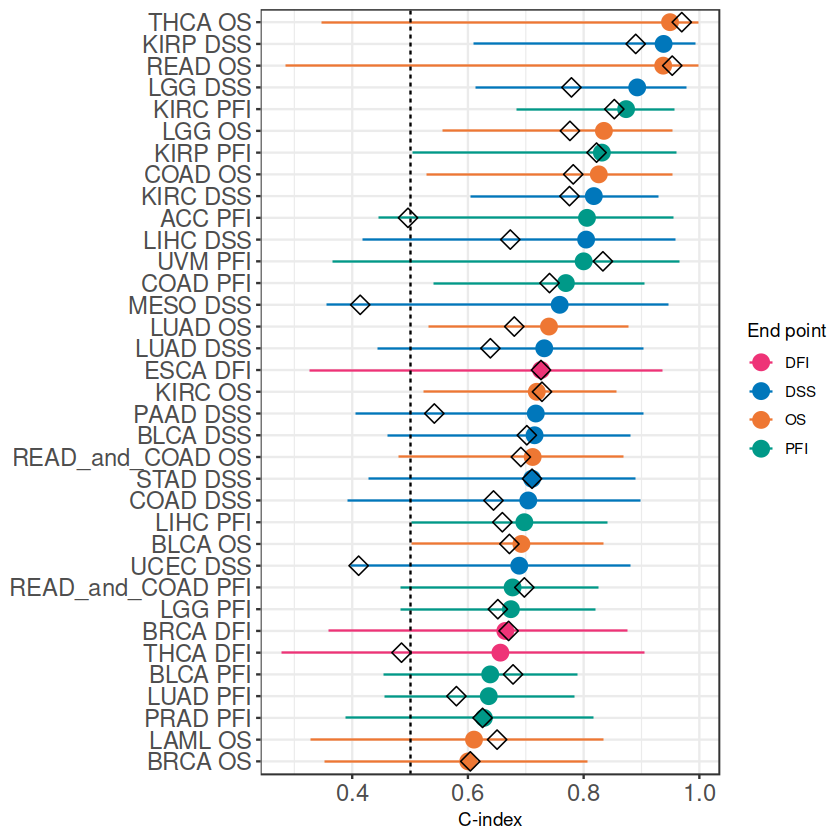

In [72]:
final.table.merged.selected %>% ggplot() +
                                   geom_pointrange(aes(x = C.index.prog, 
                                                       y = `Model`, 
                                                       xmin = CI.lower.prog, 
                                                       xmax = CI.upper.prog, 
                                                       color = `End point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       scale_color_manual(values = c("DSS"="#0077BB", 
                                                                          "DFI"="#EE3377", 
                                                                          "OS"="#EE7733",
                                                                          "PFI"="#009988")) +  
                                    geom_point(data = final.table.merged.selected, mapping = aes(x = C.index.ref, 
                                                       y = `Model`), 
                                                       position = position_dodge(width = 0.75), size=4, shape=23) + 
                                                       theme_bw() +
                                                       theme(axis.text = element_text(size = 14)) + 
                                                       labs(y = NULL, x = "C-index") + geom_vline(xintercept = 0.5, 
                                                                                        linetype = "dashed")

In [73]:
ggsave(pointrange.plot.v2,
       filename = file.path(out.dir.figures, "forestplot_all_sign_models_comb.pdf"), width = 8, height = 12)

In [74]:
ggsave(pointrange.plot.v2,
       filename =  "forestplot_all_sign_models_comb.pdf", width = 6, height = 12)

Divide into two plots with outperforming and underperforming

In [75]:
final.table.merged.selected$Performance = ifelse(final.table.merged.selected$C.index.prog > final.table.merged.selected$C.index.ref, 
                                          "Outperform", "Underperform")

In [76]:
final.table.merged.selected.outperf = final.table.merged.selected %>% dplyr::filter(Performance == "Outperform")

In [77]:
final.table.merged.selected.underperf = final.table.merged.selected %>% dplyr::filter(Performance == "Underperform")

In [78]:
p1 = final.table.merged.selected.outperf %>% 
                                   ggplot() +
                                   geom_pointrange(aes(x = C.index.prog, 
                                                       y = `Model`, 
                                                       xmin = CI.lower.prog, 
                                                       xmax = CI.upper.prog, 
                                                       color = `End point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       scale_color_manual(values = c("DSS"="#0077BB", 
                                                                          "DFI"="#EE3377", 
                                                                          "OS"="#EE7733",
                                                                          "PFI"="#009988")) +  
                                    geom_point(data = final.table.merged.selected.outperf, mapping = aes(x = C.index.ref, 
                                                       y = `Model`), 
                                                       position = position_dodge(width = 0.75), size=4, shape=23) + 
                                                       theme_bw() +
                                                       theme(axis.text = element_text(size = 14),
                                                            axis.text.x = element_text(colour = "black"),
                                                            axis.text.y = element_text(colour = "black")) + 
                                                       labs(y = NULL, x = "C-index") + geom_vline(xintercept = 0.5, 
                                                                                        linetype = "dashed") + xlim(c(0.25,1))

In [79]:
p2 = final.table.merged.selected.underperf %>% 
                                   ggplot() +
                                   geom_pointrange(aes(x = C.index.prog, 
                                                       y = `Model`, 
                                                       xmin = CI.lower.prog, 
                                                       xmax = CI.upper.prog, 
                                                       color = `End point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       scale_color_manual(values = c("DSS"="#0077BB", 
                                                                          "DFI"="#EE3377", 
                                                                          "OS"="#EE7733",
                                                                          "PFI"="#009988")) +  
                                    geom_point(data = final.table.merged.selected.underperf, mapping = aes(x = C.index.ref, 
                                                       y = `Model`), 
                                                       position = position_dodge(width = 0.75), size=4, shape=23) + 
                                                       theme_bw() +
                                                       theme(axis.text = element_text(size = 14),
                                                            axis.text.x = element_text(colour = "black"),
                                                            axis.text.y = element_text(colour = "black")) + 
                                                       labs(y = NULL, x = "C-index") + geom_vline(xintercept = 0.5, 
                                                                                        linetype = "dashed") + xlim(c(0.25,1))


                                                             

In [80]:
library(cowplot)

In [98]:
plots <- align_plots(p1, p2, align = 'v', axis = 'l')
test = plot_grid(plots[[1]], plots[[2]], ncol = 1, rel_heights = c(2,1))

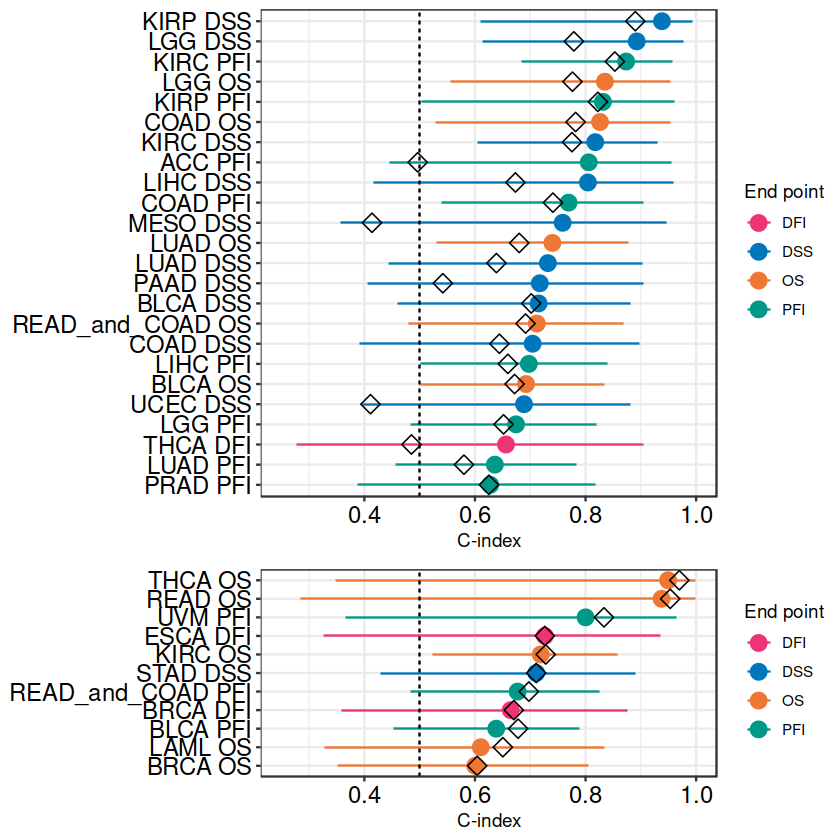

In [99]:
test

In [100]:
ggsave(test,
       filename =  "forestplot_all_sign_models_comb.v2.pdf", width = 6, height = 12)

In [84]:
# Store the results  
forest.ls = list(outperf = final.table.merged.selected.outperf, 
                 underperf = final.table.merged.selected.underperf)

saveRDS(object = forest.ls, file = "forest_plot_input.rds")

### 2. Only the "best" models 

In [85]:
final.table.merged.selected.ls = split(final.table.merged.selected, final.table.merged.selected$`Cancer type`)

In [86]:
selectBestModel = function(x){
    res =  x %>% 
            dplyr::filter(C.index.prog == max(C.index.prog))
    return(res)
}
final.table.merged.selected.best = bind_rows(map(final.table.merged.selected.ls, selectBestModel))

In [87]:
pointrange.plot.best = final.table.merged.selected.best %>% ggplot() +
                                   geom_pointrange(aes(x = C.index.prog, 
                                                       y = `Cancer type`, 
                                                       xmin = CI.lower.prog, 
                                                       xmax = CI.upper.prog, 
                                                       color = `End point`), 
                                                       position = position_dodge(width = 0.75), size=0.8) + 
                                                       scale_color_manual(values = c("DSS"="#0077BB", 
                                                                          "DFI"="#EE3377", 
                                                                          "OS"="#EE7733",
                                                                          "PFI"="#009988")) + 
                                                      theme_bw() + labs(y = NULL, x = "C-index") + geom_point(data = final.table.merged.selected.best , mapping = aes(x = C.index.ref, 
                                                       y = `Cancer type`, colour = `Reference model significant`, fill = `Reference model significant`), 
                                                       position = position_dodge(width = 0.75), size=4, shape=23) + 
                                                       theme_bw() + labs(y = NULL) + scale_fill_manual(values = c("No"="white","Yes" = "black")) +                                                       
                                                       theme(axis.text.x = element_text(colour = "black"), 
                                                             axis.text.y = element_text(colour = "black"),
                                                             legend.position = "None")
                                                       

In [88]:
ggsave(pointrange.plot.best, filename = file.path(out.dir.figures, "forestplot_best_sign_models.pdf"), 
     width = 6, height = 8) 

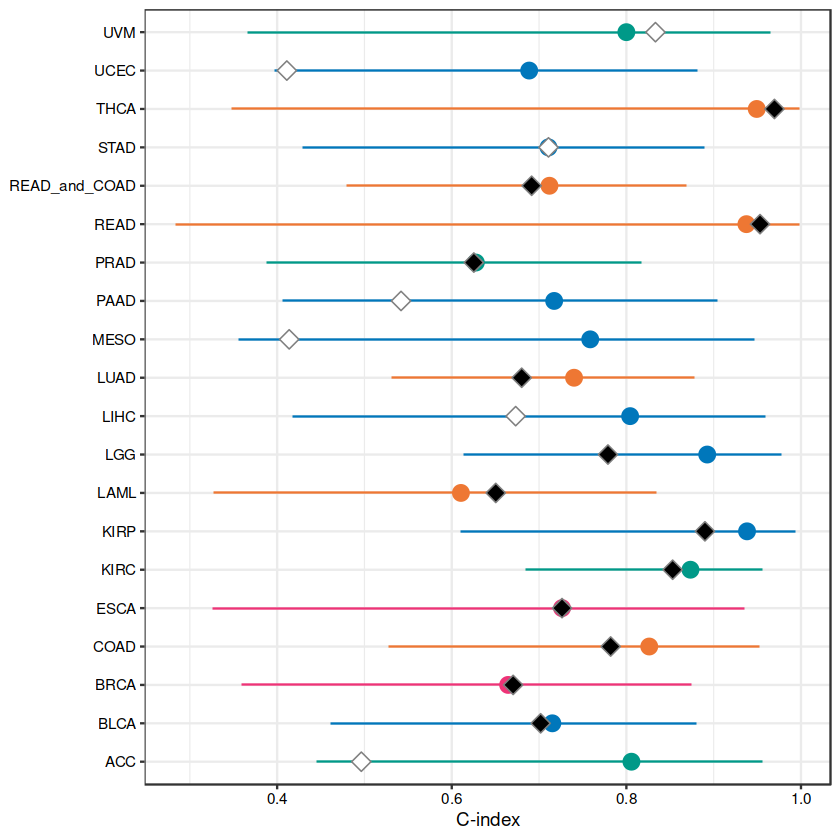

In [89]:
pointrange.plot.best